# Activity 10.01 - Normalizing and smoothing data

For this activity, all you will need is the pandas library, a scaling module from sklearn, and matplotlib. Load them in the first cell of the notebook.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

1. Use the stocks.csv dataset.

In [2]:
df=pd.read_csv('Chapter10-Datasets/stocks.csv')
df.head()

,Date,Close,Volume,symbol,sentiment
0,2017-04-17,20636.919922,229240000,S1,NEUTRAL
1,2017-04-17,20.000000,88300,S2,NEUTRAL
2,2017-04-17,5400.000000,0,S3,NEUTRAL
3,2017-04-18,20523.279297,263180000,S1,NEUTRAL
4,2017-04-18,20.150000,60500,S2,NEUTRAL


2. Inspect .dtypes and convert dates to pandas datetime if needed.

In [3]:
df.dtypes

Date          object
Close        float64
Volume         int64
symbol        object
sentiment     object
dtype: object

In [4]:
df['Date']=pd.to_datetime(df['Date'])
df['Date'].describe(datetime_is_numeric=True)

count                              753
mean     2017-10-13 07:50:26.294820608
min                2017-04-17 00:00:00
25%                2017-07-14 00:00:00
50%                2017-10-12 00:00:00
75%                2018-01-12 00:00:00
max                2018-04-13 00:00:00
Name: Date, dtype: object

3. Split the data into train and test sets based on the data, keeping the last 3 months as the test set.

In [5]:
train_end = '2018-01-13'
train = df.loc[df['Date'] <= train_end,:]
test = df.loc[df['Date']>train_end,:]

4. Generate a scatter plot that shows the prices over time of different stock symbols and identifies the train and test splits.

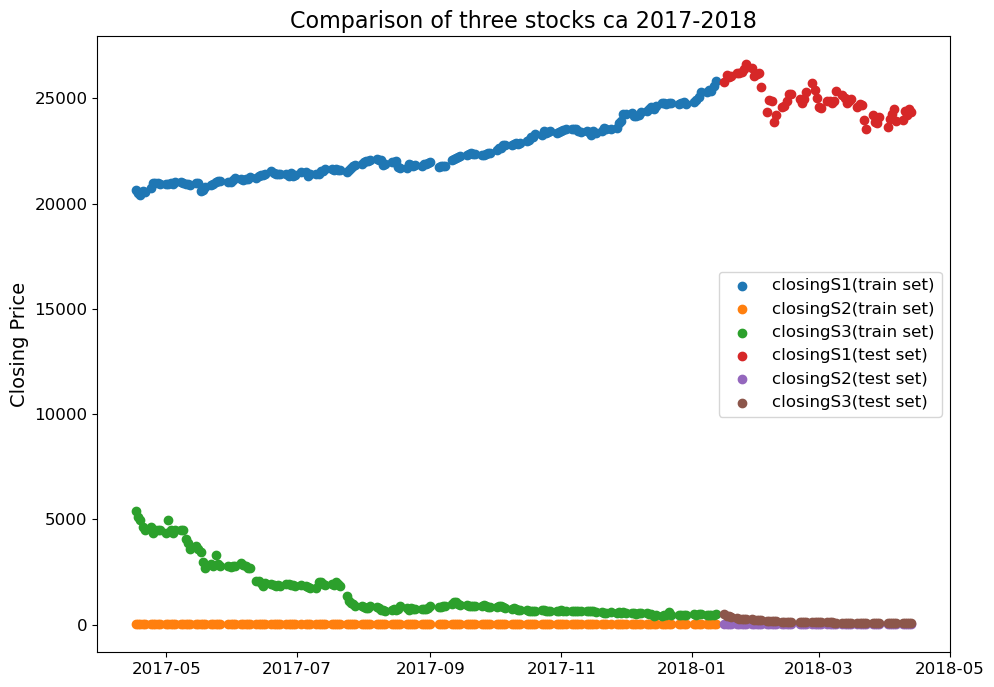

In [6]:
figure, ax=plt.subplots(figsize =(11,8))
symbols_train = train.groupby('symbol')
symbols_test = test.groupby('symbol')
for train_name, symbol_train in symbols_train:
    ax.scatter(symbol_train.Date, symbol_train.Close, label = 'closing'+train_name+'(train set)')
for test_name, symbol_test in symbols_test:
    ax.scatter(symbol_test.Date, symbol_test.Close, label ='closing'+test_name+'(test set)')
ax.legend(fontsize=12)
ax.set_ylabel('Closing Price',fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('Comparison of three stocks ca 2017-2018', fontsize =16)
plt.show()

5. You will find that the initial scatter plot isn't very informative, because different symbols have very different pricing, so some are compressed at the bottom of the y axis. Plot a histogram of the price distribution for each symbol separately, and use enough bins to see the detail.

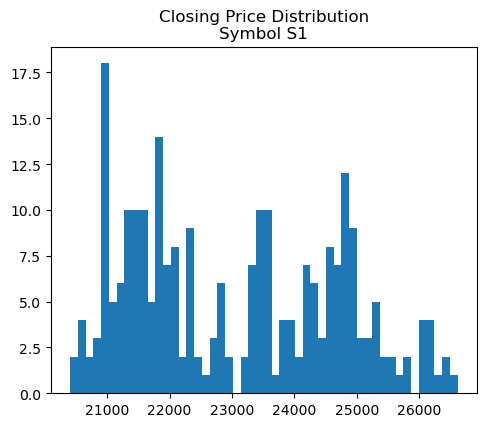

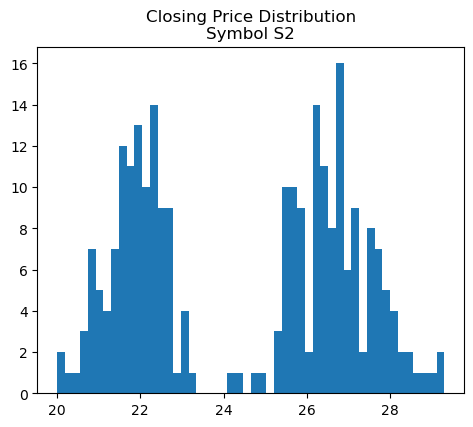

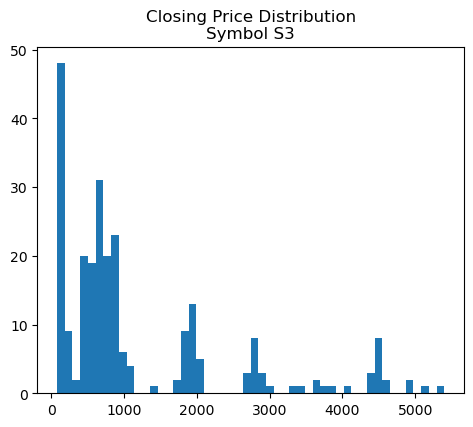

In [7]:
symbols = df.symbol.unique()
for i in range(len(symbols)):
    fig, ax = plt.subplots(figsize = (5.5, 4.5))
    ax.hist(df.groupby('symbol').get_group(symbols[i])['Close'], bins=50)
    ax.set_title('Closing Price Distribution\nSymbol '+symbols[i])
plt.show()

6. Since you see the prices have very different ranges, you need to scale each symbol separately. Use sklearn's StandardScaler to scale the original price and volume data by symbol, storing each symbol as a new DataFrame in a list, with scalers as another list.

In [8]:
scale_cols=['Close','Volume'] # to which columns we'll apply a scaler
scalers=[] # to keep a record of the scaler method used for each symbol
scaled_data = [] # to store scaled data in a list
for this_symbol in range(len(symbols)):
    scalers.append(StandardScaler())
    (scaled_data.append(df.groupby('symbol').get_group(symbols[this_symbol]).copy()))
    scaled_data[this_symbol].loc[:, scale_cols]=(scalers[this_symbol].fit_transform(scaled_data[this_symbol].loc[:,scale_cols]))
[data.head() for data in scaled_data]

[         Date     Close    Volume symbol sentiment
 0  2017-04-17 -1.469506 -1.175399     S1   NEUTRAL
 3  2017-04-18 -1.538998 -0.840327     S1   NEUTRAL
 6  2017-04-19 -1.611638 -0.528257     S1   NEUTRAL
 9  2017-04-20 -1.505101 -0.354008     S1       POS
 14 2017-04-21 -1.524028  0.210303     S1   NEUTRAL,
          Date     Close    Volume symbol sentiment
 1  2017-04-17 -1.757829  0.198494     S2   NEUTRAL
 4  2017-04-18 -1.699092 -0.359611     S2   NEUTRAL
 7  2017-04-19 -1.640355  0.351069     S2   NEUTRAL
 10 2017-04-20 -1.424984 -0.443929     S2       POS
 12 2017-04-21 -1.483721 -0.259233     S2   NEUTRAL,
          Date     Close    Volume symbol sentiment
 2  2017-04-17  3.342186 -0.211226     S3   NEUTRAL
 5  2017-04-18  3.104449 -0.211226     S3   NEUTRAL
 8  2017-04-19  2.985580 -0.211226     S3   NEUTRAL
 11 2017-04-20  2.747843 -0.211226     S3       NEG
 13 2017-04-21  2.628974 -0.211226     S3   NEUTRAL]

7. Plot the train/test data as before, using a loop over the symbols.

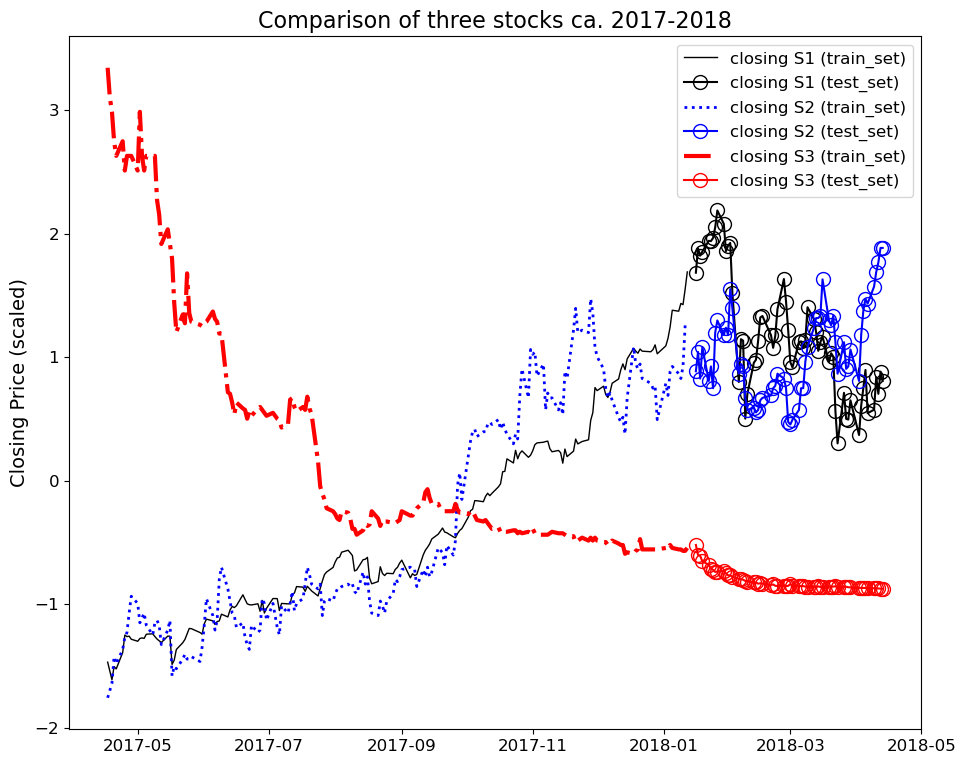

In [9]:
linestyles = ['solid','dotted','dashdot']
colors = ['black','blue','red']
figure, ax = plt.subplots(figsize=(11,9))
for this_symbol in range(len(symbols)):
    train=(scaled_data[this_symbol].loc[scaled_data[this_symbol]['Date']<=train_end,:])
    test =(scaled_data[this_symbol].loc[scaled_data[this_symbol]['Date']>train_end,:])
    ax.plot(
        train.Date, 
        train.Close,
        linestyle= linestyles[this_symbol],
        lw=this_symbol+1,
        color=colors[this_symbol],
        label= 'closing '+symbols[this_symbol]+' (train_set)')
    ax.plot(
        test.Date, 
        test.Close,
        'o-',
        fillstyle = 'none', 
        markersize = 10,
        color=colors[this_symbol],
        label= 'closing '+symbols[this_symbol]+' (test_set)')
    
ax.legend(fontsize=12)
ax.set_ylabel('Closing Price (scaled)', fontsize = 14)
ax.tick_params(labelsize=12)
ax.set_title('Comparison of three stocks ca. 2017-2018', fontsize=16)
plt.show()    

8. You can now see that two of the symbols are similar in trend and one differes. Replot the two similar symbols but apply smoothing of 14 days and compare whether the two stocks are behaving the same way over the period from 2017-19 forward.

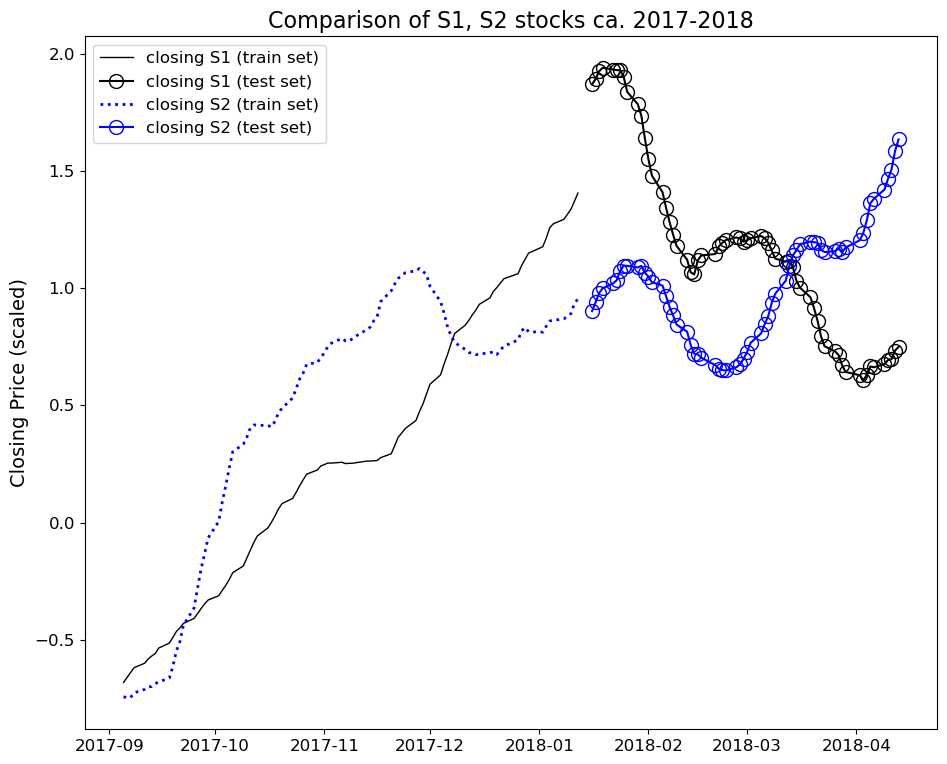

In [10]:
start_date = '2017-09-01'
fig, ax = plt.subplots(figsize = (11,9))
for this_symbol in [0,1]:
    train = (scaled_data[this_symbol].copy().loc[scaled_data[this_symbol]['Date']<=train_end,:])
    train = train.loc[train['Date']>start_date,:]
    train.Close = train.Close.rolling(window=14,min_periods=0,center=True).mean()
    
    test=(scaled_data[this_symbol].copy().loc[scaled_data[this_symbol]['Date']>train_end, :])
    test = test.loc[test['Date']>start_date,:]
    test.Close=test.Close.rolling(window=14,min_periods=0,center=True).mean()
    
    ax.plot(
        train.Date,
        train.Close,
        linestyle=linestyles[this_symbol],
        lw=this_symbol+1,
        c=colors[this_symbol],
        label='closing '+symbols[this_symbol]+' (train set)'
    )
    ax.plot(
        test.Date,
        test.Close,
        'o-',
        fillstyle = 'none',
        markersize = 10,
        c=colors[this_symbol],
        label='closing '+symbols[this_symbol]+' (test set)'
    )
    
ax.legend(fontsize=12)
ax.set_ylabel('Closing Price (scaled)', fontsize=14)
ax.tick_params(labelsize =12)
ax.set_title('Comparison of S1, S2 stocks ca. 2017-2018', fontsize=16)
plt.show()

The result should indicate some potential similarities between two of thesymbols' prices behavior, which motivates some additional market research to look for reasons why they behave this way.